In [1]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import sys
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

# Add parent directory to path to import from app_exp.py
sys.path.append('..')
from app_exp2 import (
    run_monte_carlo_simulations,
    gamma_exponential,
    generate_poisson_process_nonhomogeneous
)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [3]:
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['figure.dpi'] = 300

# Create output directory for plots
output_dir = Path('plots')
output_dir.mkdir(exist_ok=True)

In [4]:
# parameter optimization

In [5]:
import numpy as np
import plotly.graph_objects as go
from scipy.optimize import curve_fit

# Define the model function: f(x) = A*(1 - c*exp(-d*x))
def model(x, A, c, d):
    return A * (1 - c * np.exp(-d * x))

# Arbitrary data points
xdata = np.array([4, 6, 15, 100])
ydata = np.array([0.25, 0.30, 0.50, 1.0])

# Initial guess for the parameters: [A, c, d]
initial_guess = [1.0, 0.9, 0.03]

# Perform the curve fit
popt, pcov = curve_fit(model, xdata, ydata, p0=initial_guess)
A_fit, c_fit, d_fit = popt

print("Fitted parameters:")
print(f"A = {A_fit:.4f}")
print(f"c = {c_fit:.4f}")
print(f"d = {d_fit:.4f}")

# Define the fitted function using the optimal parameters
def f_fit(x):
    return model(x, A_fit, c_fit, d_fit)

# Generate x values for the fitted curve
x_fit = np.linspace(0, 110, 500)
y_fit = f_fit(x_fit)

# Compute the fitted values at the original data points (for verification)
y_points = f_fit(xdata)

# Create the Plotly figure
fig = go.Figure()

# Add the fitted curve
fig.add_trace(go.Scatter(
    x=x_fit,
    y=y_fit,
    mode='lines',
    name=r'Fitted: $\Gamma(n)=A(1-ce^{-dn})$'
))

# Add the original data points as markers
fig.add_trace(go.Scatter(
    x=xdata,
    y=ydata,
    mode='markers',
    marker=dict(size=10, color='red'),
    name='Data Points'
))

# Update layout details
fig.update_layout(
    title=r'Least–Squares Fit of $\Gamma(n)=A(1 - c \cdot \exp(-d n))$',
    xaxis_title=r'$n$',
    yaxis_title=r'$\Gamma(n)$',
    xaxis=dict(range=[0, 110])
)

# Display the plot
fig.show()


Fitted parameters:Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.

A = 1.0259
c = 0.8730
d = 0.0354


## Simulation Configuration

Here we define the parameters for our simulation run.

In [6]:
# Simulation parameters
config = {
    'n_simulations': 10,  # Number of Monte Carlo simulations
    'total_weeks': 800,    # Total number of rounds
    'initial_poisson_value': 4,  # Initial number of challenges
    'vault_start_week': 62,  # When the vault policy starts
    'gamma_start_y': 00,   # Initial gamma value
    'a': A_fit,
    'b': c_fit,
    'c': d_fit,
    # 'rate_func_str': '0.01 + 0.0005*(t-62)'  # Rate function for non-homogeneous Poisson
    'rate_func_str': '0.16025641025641027 + 0.001232741617357002*(t-62)'
    # 'rate_func_str': '0.13647642679900746'  # very pessimistic, will result in a lot of dumping at the end (very bearish)
    # 'rate_func_str': '1'  # very bullshi
    # 'rate_func_str': '0.1*(t<52) + 10/312*(t<312)*(t>52) + 1e-3*(t>312)'
}

# Define the rate function
def rate_func(t):
    return eval(config['rate_func_str'], {'t': t, 'np': np, '__builtins__': {}})

print("Simulation Configuration:")
for key, value in config.items():
    print(f"{key}: {value}")

Simulation Configuration:
n_simulations: 10
total_weeks: 800
initial_poisson_value: 4
vault_start_week: 62
gamma_start_y: 0
a: 1.0259225620655181
b: 0.8730263380660264
c: 0.03543482667675584
rate_func_str: 0.16025641025641027 + 0.001232741617357002*(t-62)


In [7]:
# Run the simulation
results = run_monte_carlo_simulations(
    n_simulations=config['n_simulations'],
    total_weeks=config['total_weeks'],
    mean_interarrival_time=1.0,  # Dummy value, not used for non-homogeneous
    gamma_func=gamma_exponential,
    gamma_func_params=(config['a'], config['b'], config['c']),
    use_nonhomogeneous=True,
    custom_rate_func=rate_func,
    initial_poisson_value=config['initial_poisson_value'],
    vault_start_week=config['vault_start_week']
)

In [8]:
# Create a DataFrame for easier plotting
df = pd.DataFrame({
    'Round': results['time'],
    'Original_Schedule': results['M']/1e6,
    'Cumulative_Minted': results['median']['cumulative_minted']/1e6,
    'Cumulative_Minted_Lower': results['lower_ci']['cumulative_minted']/1e6,
    'Cumulative_Minted_Upper': results['upper_ci']['cumulative_minted']/1e6,
    'Cumulative_Vault': results['median']['cumulative_vault']/1e6,
    'Cumulative_Vault_Lower': results['lower_ci']['cumulative_vault']/1e6,
    'Cumulative_Vault_Upper': results['upper_ci']['cumulative_vault']/1e6,
    'Gamma': results['median']['gamma'],
    'Gamma_Lower': results['lower_ci']['gamma'],
    'Gamma_Upper': results['upper_ci']['gamma'],
    'Total_Challenges': results['median']['G'],
    'Total_Challenges_Lower': results['lower_ci']['G'],
    'Total_Challenges_Upper': results['upper_ci']['G'],
    'Active_Side': results['active_side']
})

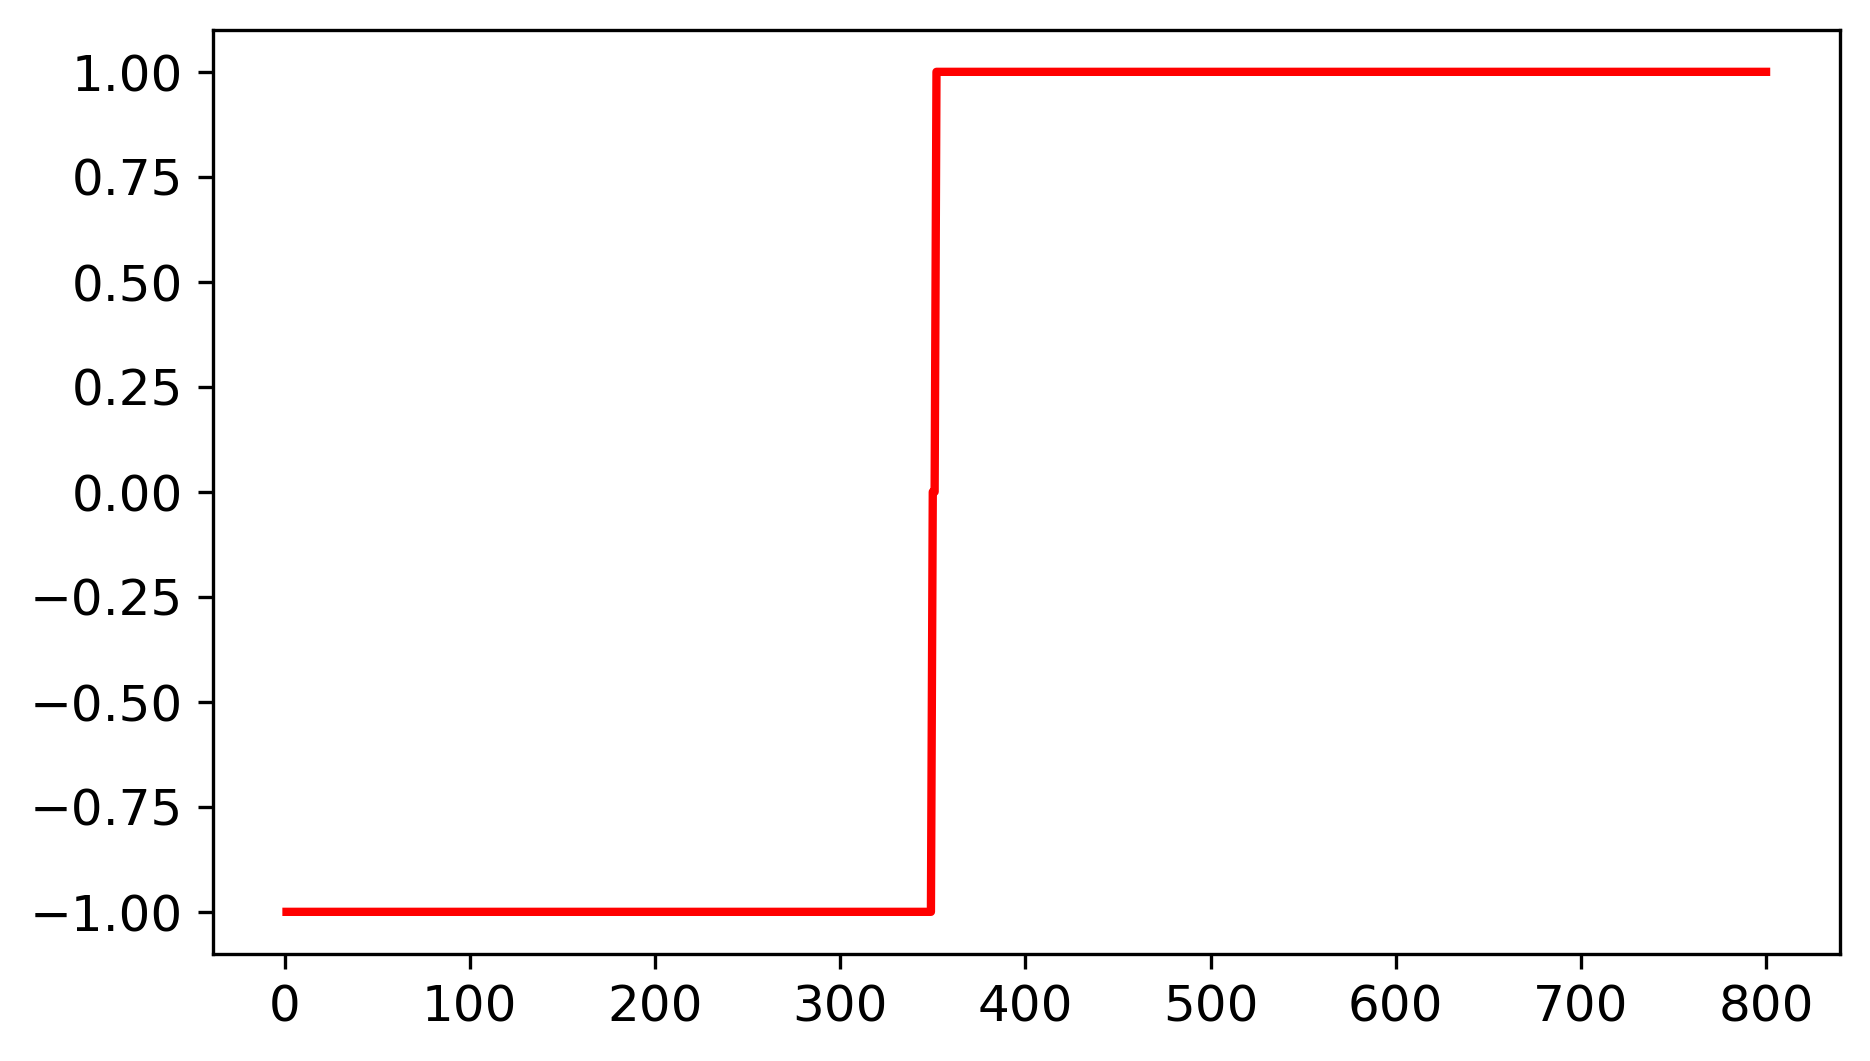

In [9]:
plt.figure(figsize=(7, 4))
plt.plot(df['Round'], df['Active_Side'], color='red', linewidth=2)

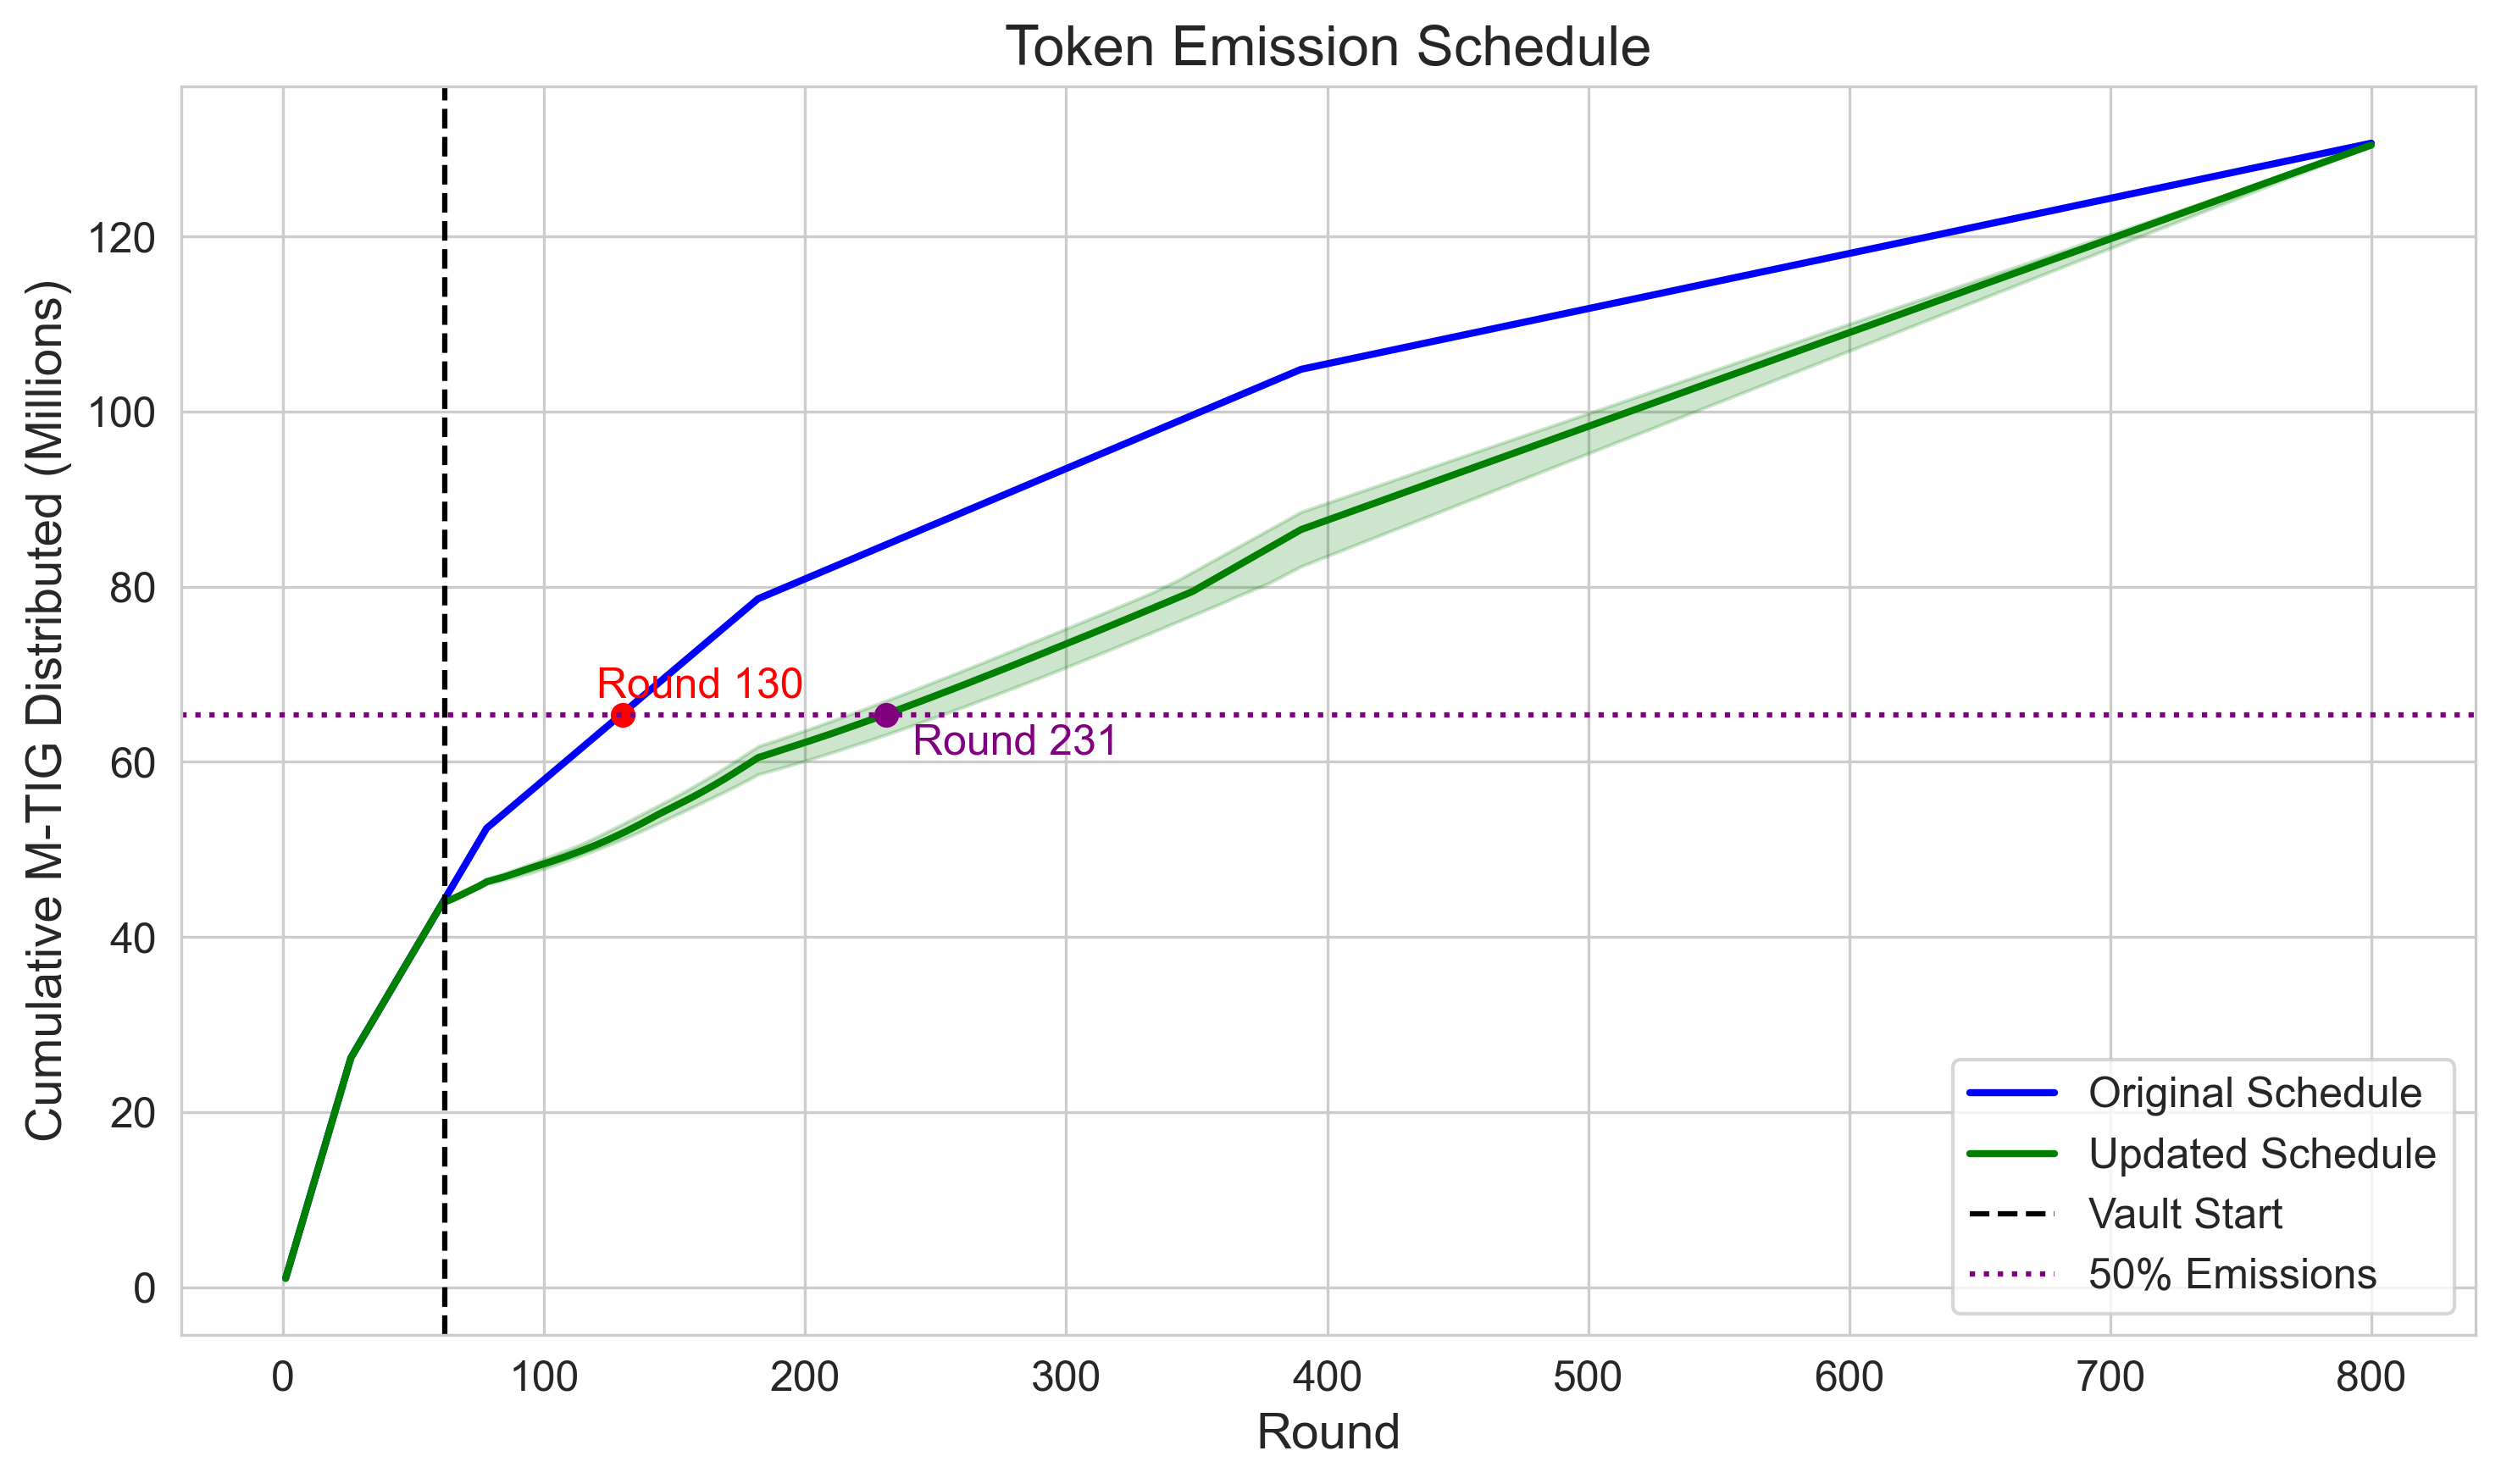

In [10]:
# Plot 1: Emission Schedule
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Plot original schedule
plt.plot(df['Round'], df['Original_Schedule'], 
         label='Original Schedule', color='blue', linewidth=2)

# Plot simulated schedule with confidence intervals
plt.plot(df['Round'], df['Cumulative_Minted'], 
         label='Updated Schedule', color='green', linewidth=2)
plt.fill_between(df['Round'], df['Cumulative_Minted_Lower'], 
                 df['Cumulative_Minted_Upper'], 
                 color='green', alpha=0.2)

# Add vault start line
plt.axvline(x=config['vault_start_week'], color='black', 
            linestyle='--', label='Vault Start')

# Calculate total emissions and find 50% point for original schedule
total_emissions = df['Original_Schedule'].iloc[-1]
half_emissions = total_emissions / 2

# Find the round where we reach 50% emissions for original schedule
half_emission_round = df[df['Original_Schedule'] >= half_emissions].index[0]
gamma_at_half = df['Gamma'].iloc[half_emission_round]

# half emissions indicators
# plt.axhline(y=half_emissions, color='red', linestyle=':', label='50% Emissions (Original)')
# plt.axvline(x=df['Round'].iloc[half_emission_round], color='red', linestyle=':')
# plt.scatter(df['Round'].iloc[half_emission_round], half_emissions, color='red', s=100, zorder=5, label='50% Emissions (Original)')

plt.plot(df['Round'].iloc[half_emission_round], half_emissions, 'ro')  # Red dot
# Add text annotation for original schedule
plt.text(df['Round'].iloc[half_emission_round] - 10, half_emissions + 1,
         f'Round {df["Round"].iloc[half_emission_round]}',
         verticalalignment='bottom', color='red')
# plt.annotate(f'Round {df["Round"].iloc[half_emission_round]}',
#             xy=(df['Round'].iloc[half_emission_round], half_emissions),
#             xytext=(10, -10),  # 10 points offset
#             textcoords='offset points',
#             ha='left',
#             va='top',
#             bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.1),
#             arrowprops=dict(arrowstyle='->'))

# Find the round where we reach 50% emissions for simulated schedule
sim_half_emission_round = df[df['Cumulative_Minted'] >= half_emissions].index[0]
sim_gamma_at_half = df['Gamma'].iloc[sim_half_emission_round]

# Add vertical line at the round where we reach 50% emissions for simulated schedule
plt.axhline(y=half_emissions, color='purple', linestyle=':', label='50% Emissions')
# plt.axvline(x=df['Round'].iloc[sim_half_emission_round], color='purple', linestyle=':', label='50% Emissions (Updated)')

# Add text annotation for simulated schedule
plt.plot(df['Round'].iloc[sim_half_emission_round], half_emissions, color='purple', marker='o')  # Red dot
plt.text(df['Round'].iloc[sim_half_emission_round] + 10, half_emissions - 1,
         f'Round {df["Round"].iloc[sim_half_emission_round]}',
         verticalalignment='top', color='purple')


plt.xlabel('Round')
plt.ylabel('Cumulative M-TIG Distributed (Millions)')
plt.title('Token Emission Schedule')
plt.legend()
plt.tight_layout()

# Save plot
plt.savefig(output_dir / 'emission_schedule.png', dpi=300, bbox_inches='tight')
plt.show()

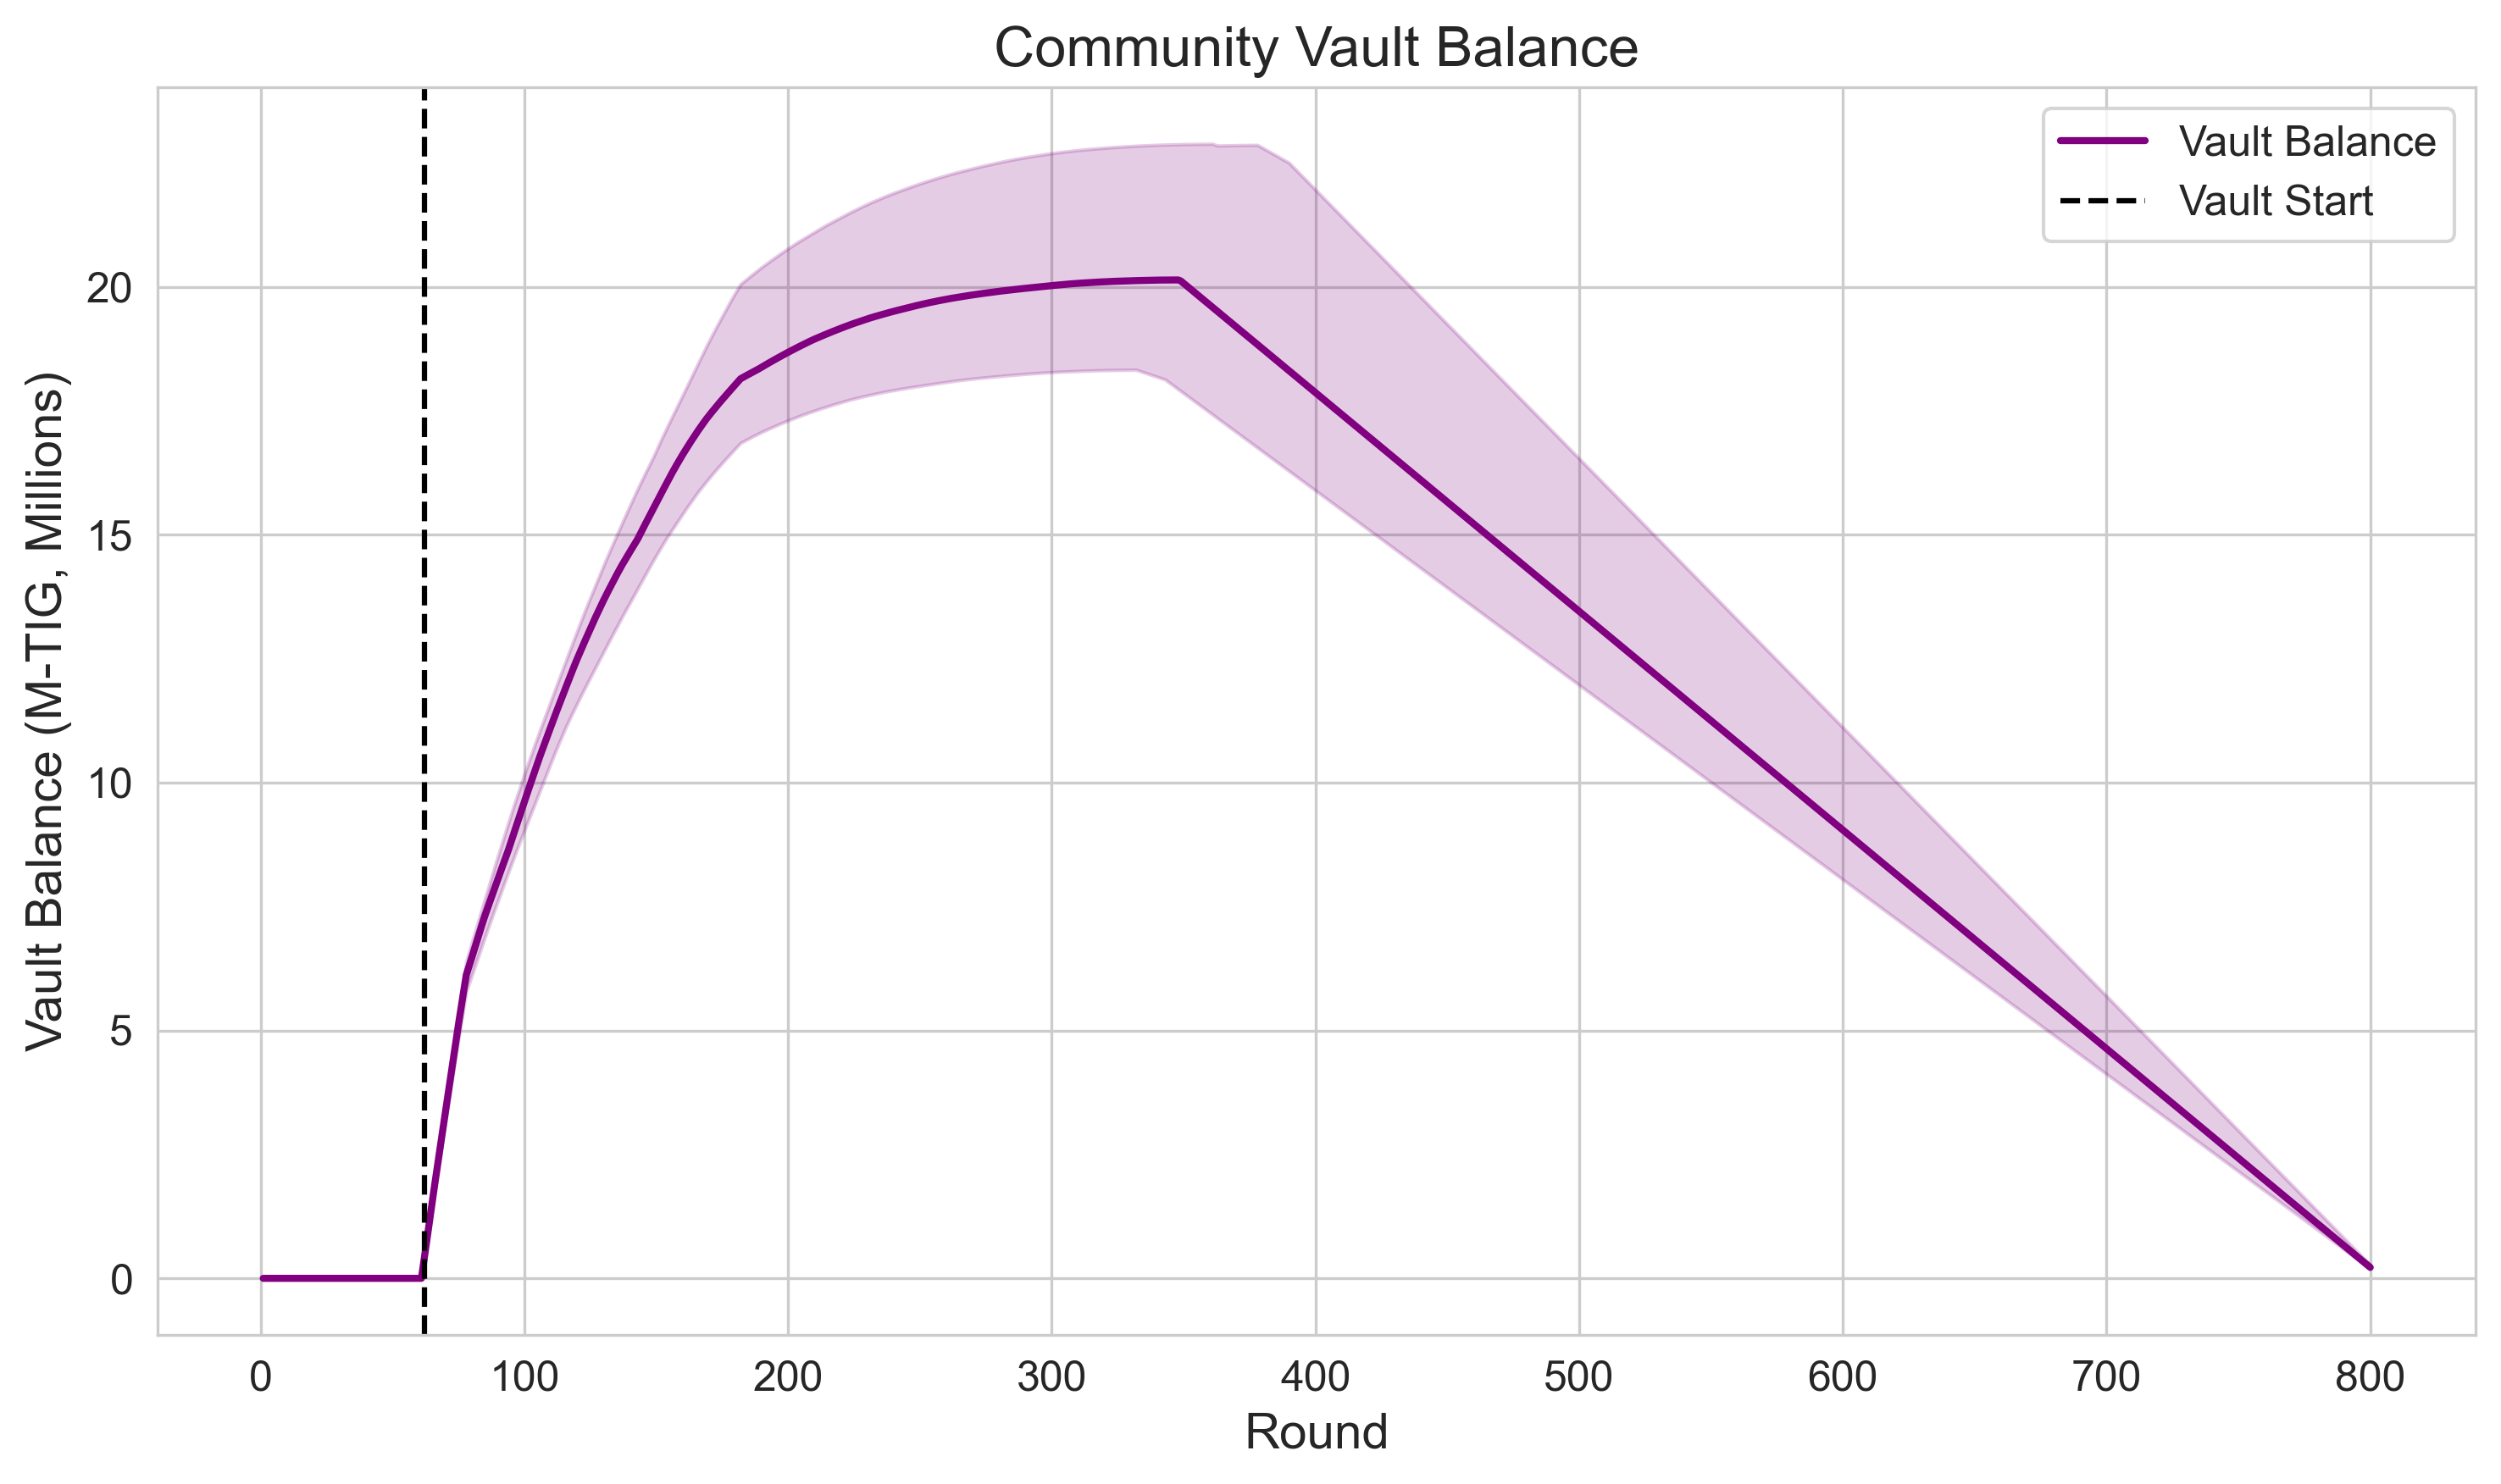

In [11]:
# Plot 2: Vault Dynamics
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Plot vault balance with confidence intervals
plt.plot(df['Round'], df['Cumulative_Vault'], 
         label='Vault Balance', color='purple', linewidth=2)
plt.fill_between(df['Round'], df['Cumulative_Vault_Lower'], 
                 df['Cumulative_Vault_Upper'], 
                 color='purple', alpha=0.2)

# Add vault start line
plt.axvline(x=config['vault_start_week'], color='black', 
            linestyle='--', label='Vault Start')

plt.xlabel('Round')
plt.ylabel('Vault Balance (M-TIG, Millions)')
plt.title('Community Vault Balance')
plt.legend()
plt.tight_layout()

# Save plot
plt.savefig(output_dir / 'vault_dynamics.png', dpi=300, bbox_inches='tight')
plt.show()

In [19]:
print(config['a'], config['b'], config['c'])

1.0259225620655181 0.8730263380660264 0.03543482667675584


TypeError: bad operand type for unary -: 'set'

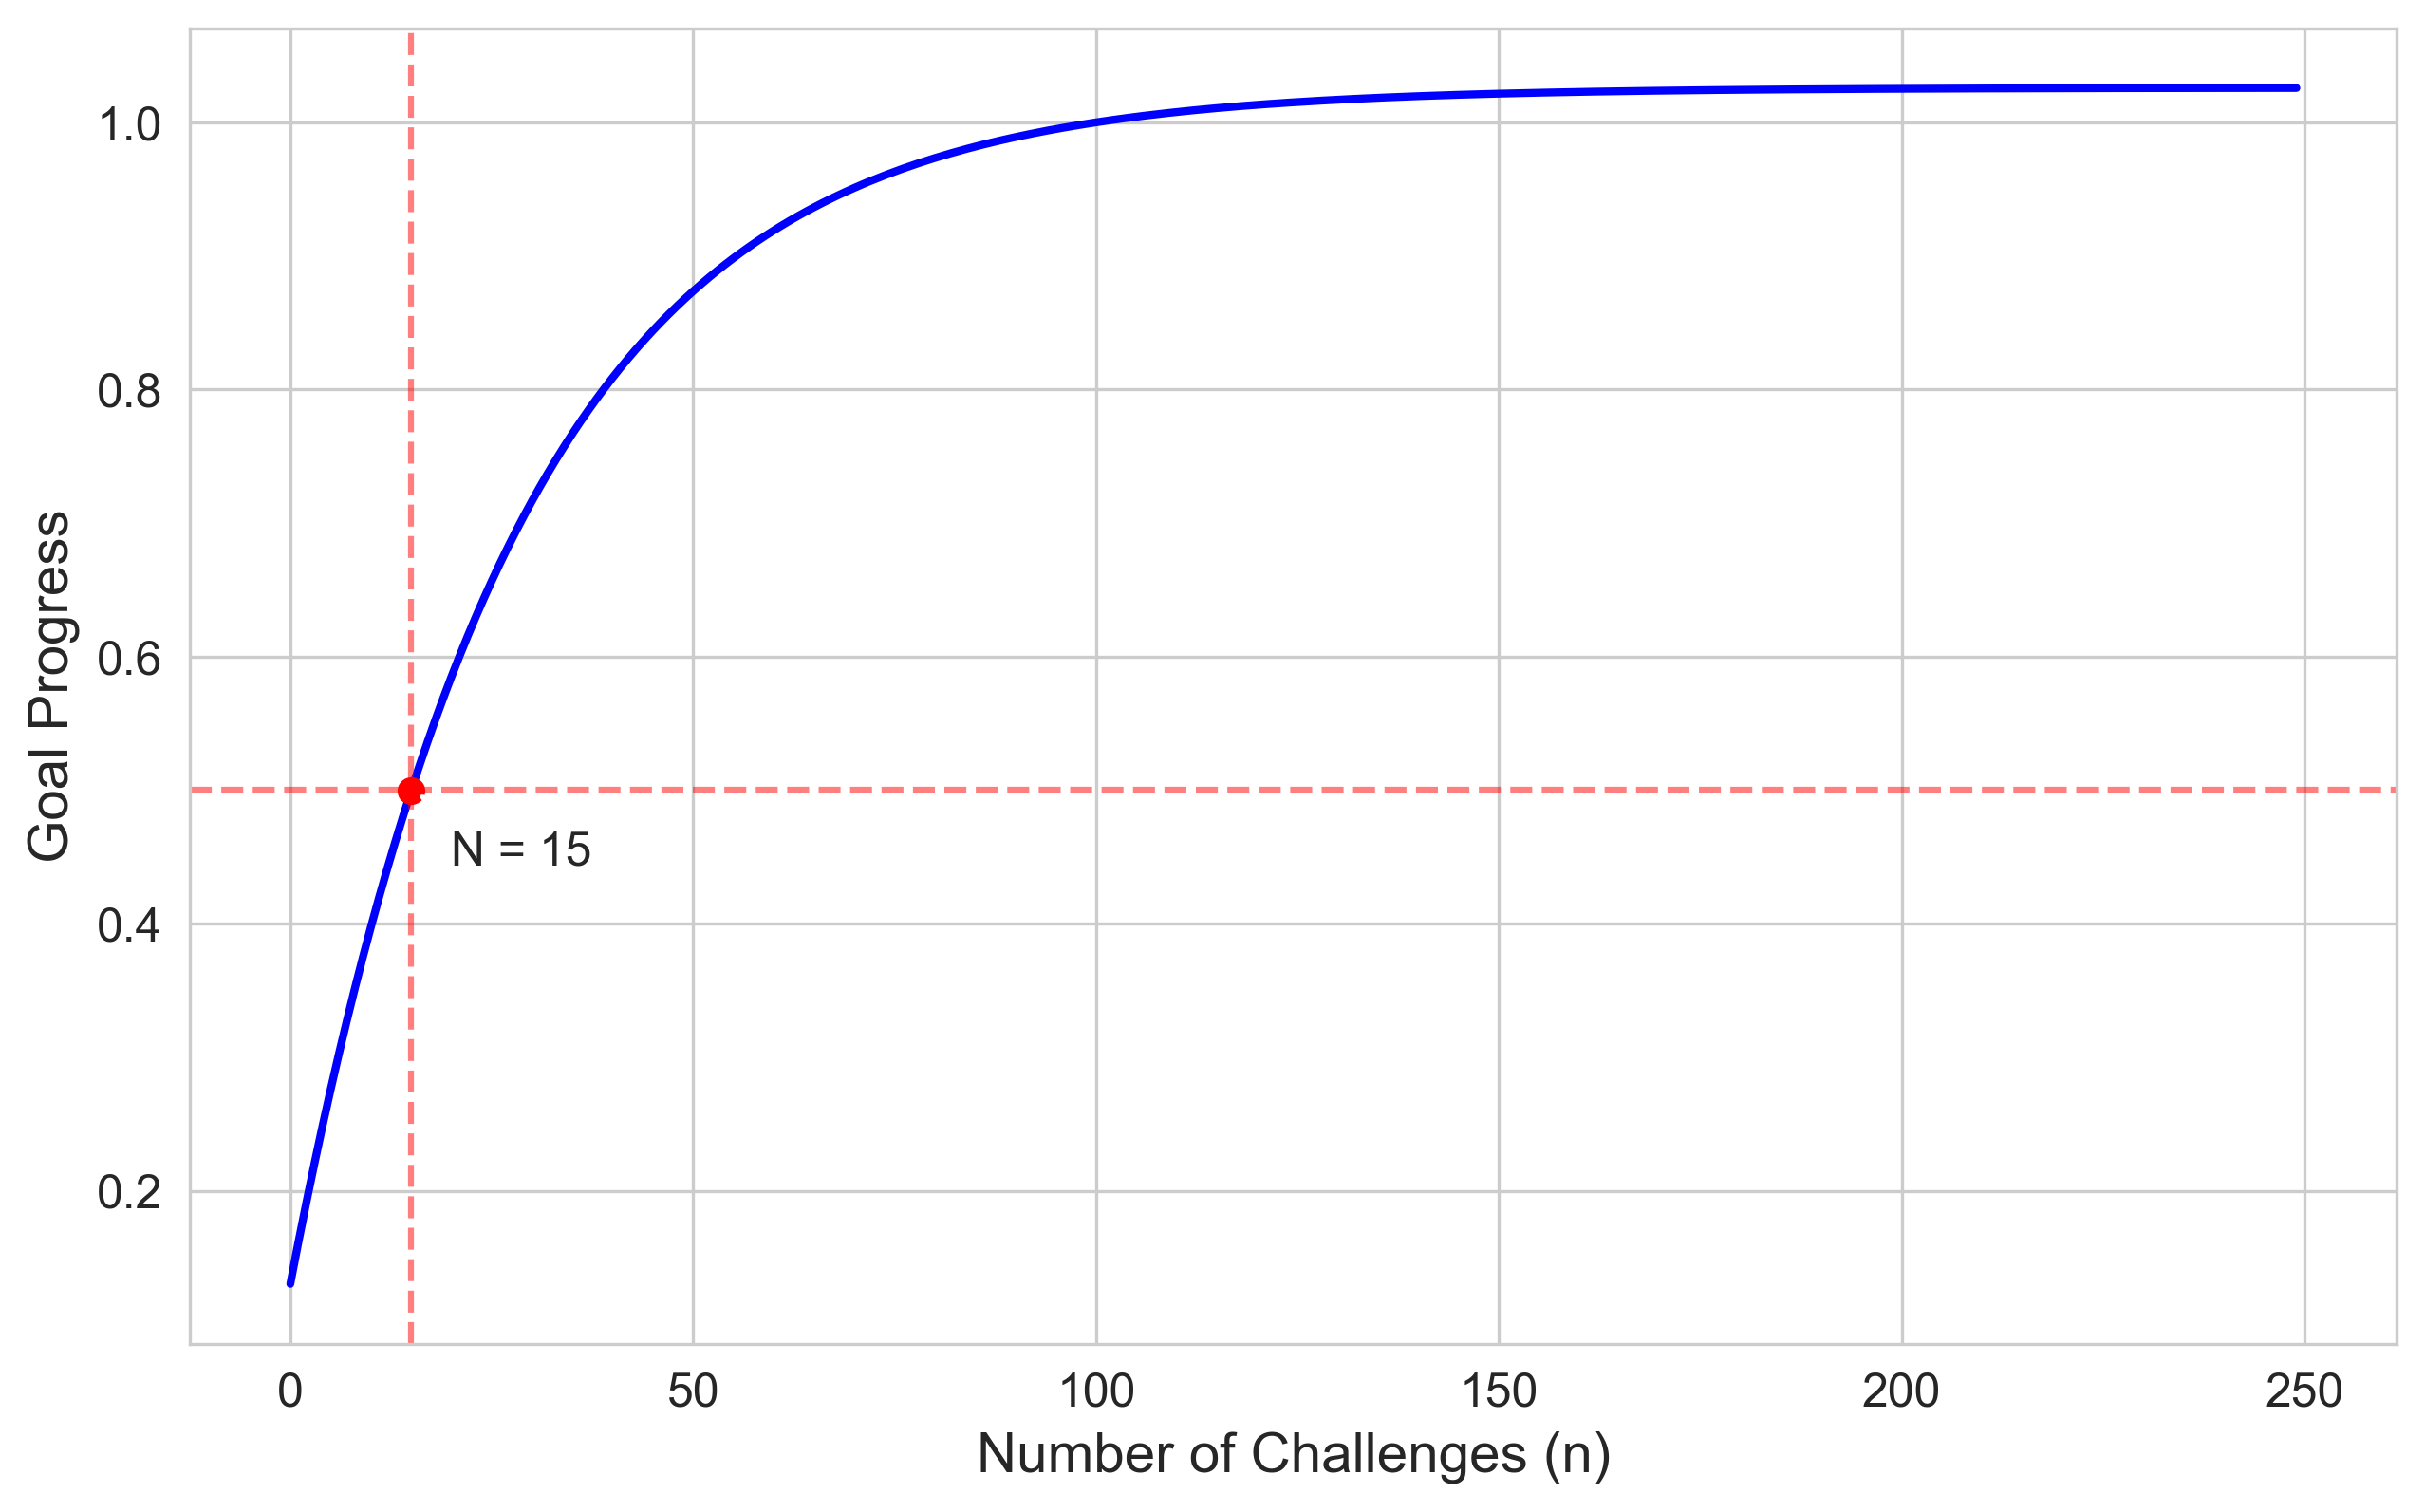

In [18]:
# Plot 5: Gamma Function
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Create data for gamma function plot
n_values = np.arange(0, 250)  # Show up to 250 challenges
gamma_values = [gamma_exponential(n, 
                                config['a'], 
                                config['b'], 
                                config['c']) 
                for n in n_values]

# Find where gamma ≈ 0.5
gamma_array = np.array(gamma_values)
n_at_half = n_values[np.abs(gamma_array - 0.5).argmin()]
gamma_at_half = gamma_values[n_at_half]

# Plot gamma function
plt.plot(n_values, gamma_values, 
         label='Gamma Function', color='blue', linewidth=2)

# Add crosshair lines at gamma = 0.5
plt.axhline(y=0.5, color='red', linestyle='--', alpha=0.5)  # Horizontal line
plt.axvline(x=n_at_half, color='red', linestyle='--', alpha=0.5)  # Vertical line

# Add dot and label for gamma = 0.5
plt.plot(n_at_half, gamma_at_half, 'ro')  # Red dot
plt.annotate(f'N = {n_at_half}',
            xy=(n_at_half, gamma_at_half),
            xytext=(10, -10),  # 10 points offset
            textcoords='offset points',
            ha='left',
            va='top',
            bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.7),
            arrowprops=dict(arrowstyle='->'))

plt.xlabel('Number of Challenges (n)')
plt.ylabel('Goal Progress')
plt.title('$\Gamma(n) = 1.0258 (1 - 0.8730 e^{-0.0354n})$')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save plot
plt.savefig(output_dir / 'gamma_function.png', dpi=300, bbox_inches='tight')
plt.show()

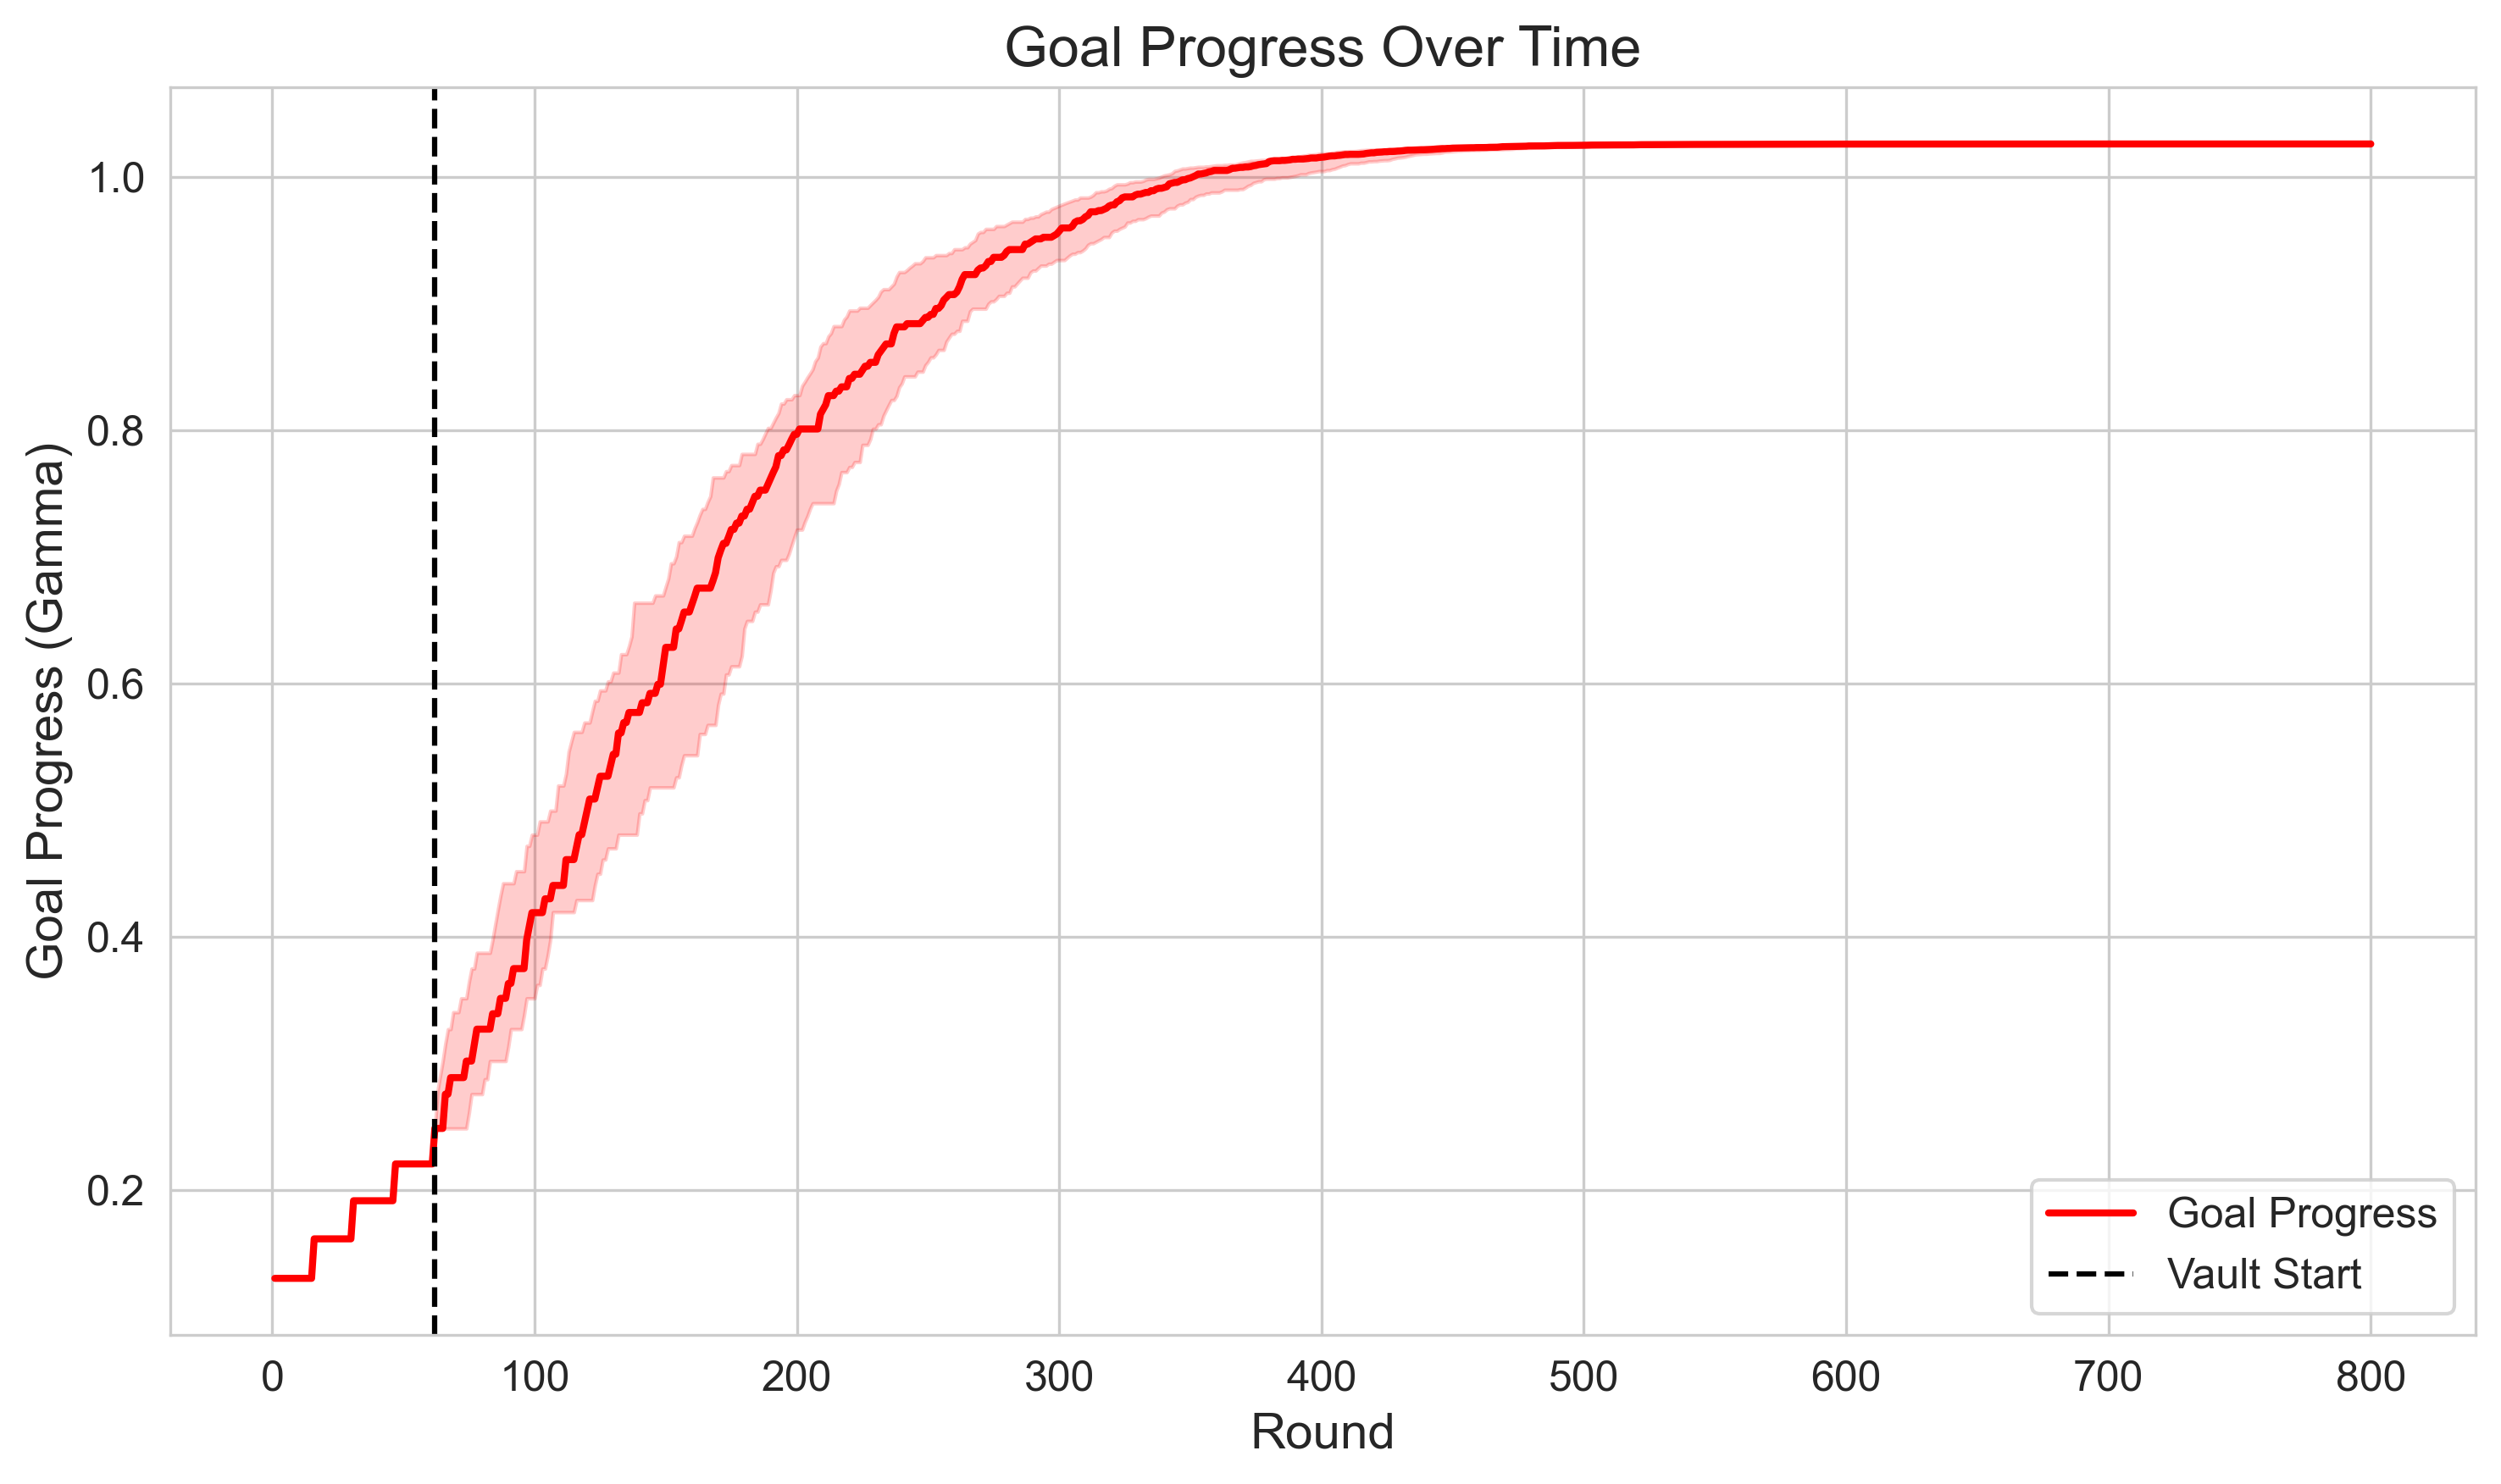

In [13]:
# Plot 3: Goal Progress (Gamma)
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Plot gamma with confidence intervals
plt.plot(df['Round'], df['Gamma'], 
         label='Goal Progress', color='red', linewidth=2)
plt.fill_between(df['Round'], df['Gamma_Lower'], 
                 df['Gamma_Upper'], 
                 color='red', alpha=0.2)

# Add vault start line
plt.axvline(x=config['vault_start_week'], color='black', 
            linestyle='--', label='Vault Start')

plt.xlabel('Round')
plt.ylabel('Goal Progress (Gamma)')
plt.title('Goal Progress Over Time')
plt.legend()
plt.tight_layout()

# Save plot
plt.savefig(output_dir / 'goal_progress.png', dpi=300, bbox_inches='tight')
plt.show()

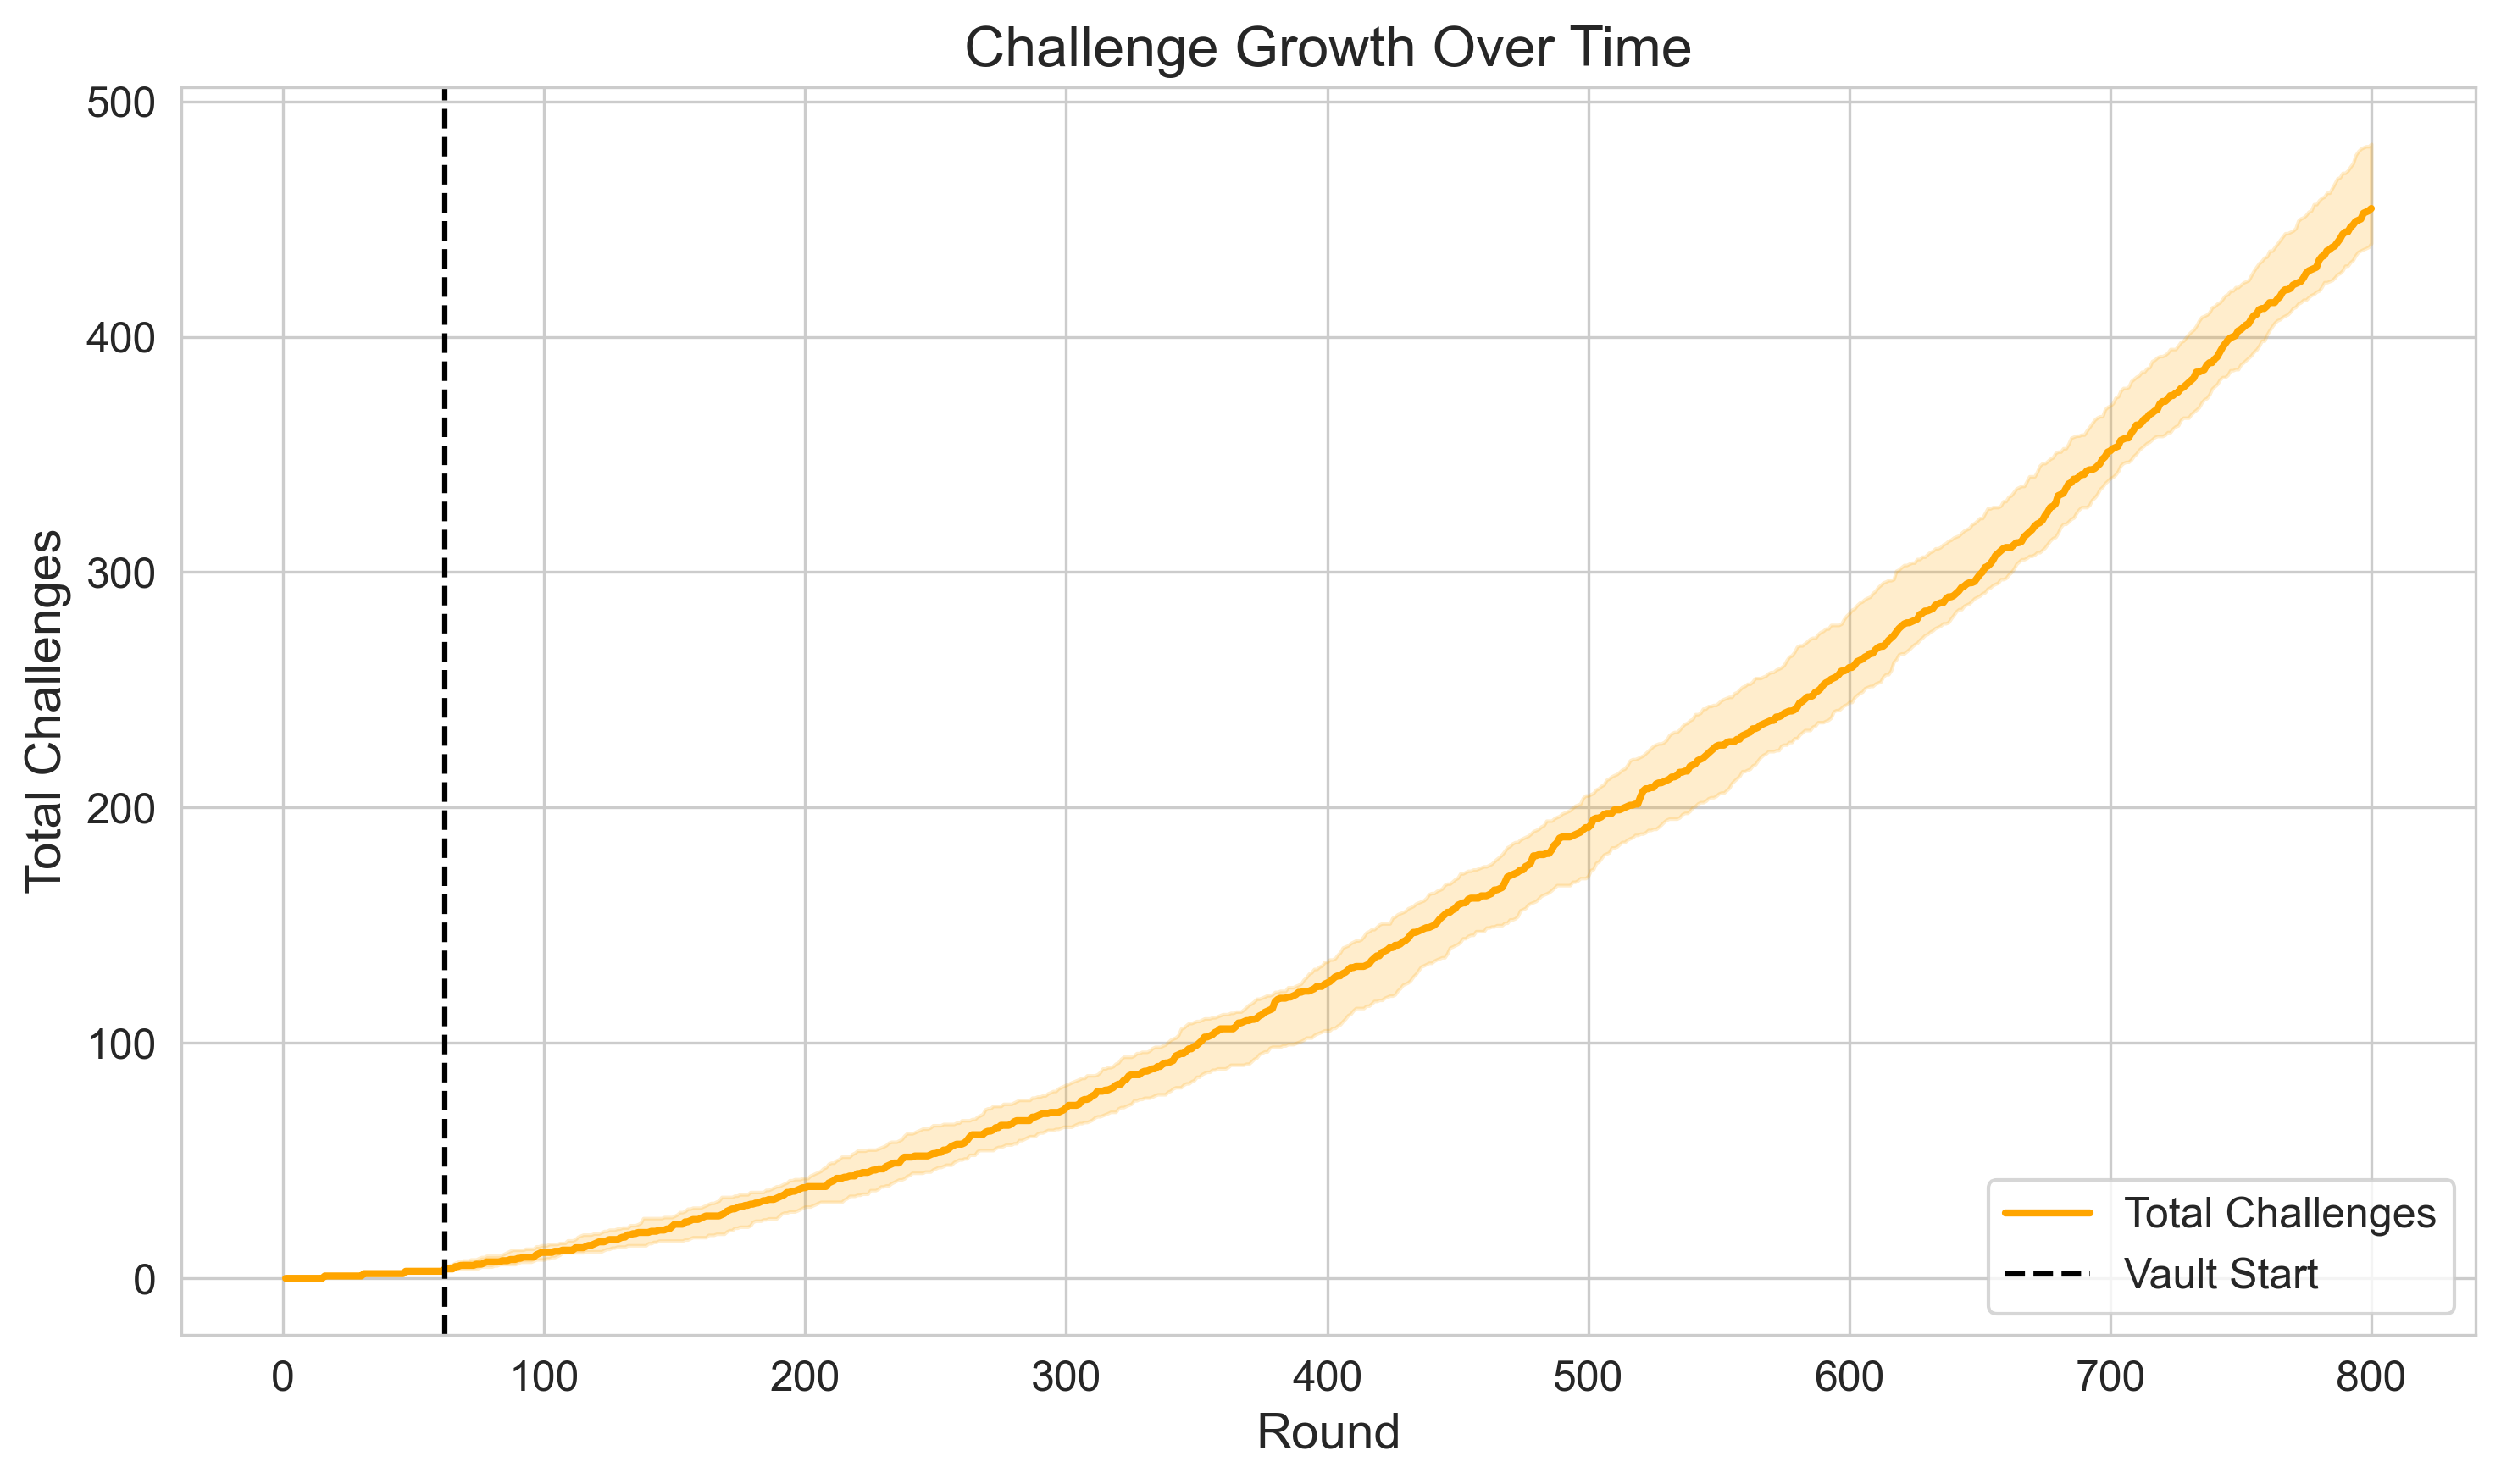

In [14]:
# Plot 4: Total Challenges
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Plot total challenges with confidence intervals
plt.plot(df['Round'], df['Total_Challenges'], 
         label='Total Challenges', color='orange', linewidth=2)
plt.fill_between(df['Round'], df['Total_Challenges_Lower'], 
                 df['Total_Challenges_Upper'], 
                 color='orange', alpha=0.2)

# Add vault start line
plt.axvline(x=config['vault_start_week'], color='black', 
            linestyle='--', label='Vault Start')

plt.xlabel('Round')
plt.ylabel('Total Challenges')
plt.title('Challenge Growth Over Time')
plt.legend()
plt.tight_layout()

# Save plot
plt.savefig(output_dir / 'challenge_growth.png', dpi=300, bbox_inches='tight')
plt.show()

In [15]:
n_vals = [4, 6, 10, 15, 100]
for n in n_vals:
    print(f'Gamma at {n}: {gamma_exponential(n, config["a"], config["b"], config["c"])}')

Gamma at 4: 0.24862853918588773
Gamma at 6: 0.30180842107580924
Gamma at 10: 0.39750193753101354
Gamma at 15: 0.4995361360838498
Gamma at 100: 1.0000269036568457


## Key Metrics

Print out the key metrics from the simulation.

In [16]:
print("Key Metrics at Final Round:")
print(f"Median Total Minted: {df['Cumulative_Minted'].iloc[-1]:.2f}M M-TIG")
print(f"Median Vault Balance: {df['Cumulative_Vault'].iloc[-1]:.2f}M M-TIG")
print(f"Median Total Challenges: {df['Total_Challenges'].iloc[-1]:.0f}")
print(f"Final Gamma Value: {df['Gamma'].iloc[-1]:.3f}")

Key Metrics at Final Round:
Median Total Minted: 130.44M M-TIG
Median Vault Balance: 0.22M M-TIG
Median Total Challenges: 454
Final Gamma Value: 1.026
